In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
from src.multi_vae_pemb import CrossSpeciesVAE
# from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata1 = anndata.read_h5ad('data/wagner/data.h5ad')
adata2 = anndata.read_h5ad('data/briggs/data.h5ad')

adata1.X = adata1.X.astype('float32')
adata2.X = adata2.X.astype('float32')

emb1 = pickle.load(open('data/wagner/gene_embeddings.pkl','rb'))
emb2 = pickle.load(open('data/briggs/gene_embeddings.pkl','rb'))

emb1 = torch.cat([torch.tensor(emb1[i]).unsqueeze(-2) for i in adata1.var_names],dim=0).float()
emb2 = torch.cat([torch.tensor(emb2[i]).unsqueeze(-2) for i in adata2.var_names],dim=0).float()

I found that homology edges derived from ESM-C give better-than-random mappings. Real signal.


Learning rate needs to be lower to get integration to be better, I've found.




In [14]:
species_data = {
    "wagner": adata1,
    "briggs": adata2,
}

emb_data = {
    "wagner": emb1,
    "briggs": emb2, 
}
data_module = CrossSpeciesDataModule(
    species_data = species_data,
    batch_size=512,
    num_workers=0,
    val_split=0.001,
    test_split=0.001,
    yield_pairwise=False,
    subsample_size=30000,
    subsample_by={
        "wagner": "cell_type",
        "briggs": "cell_type",   
    }
)
data_module.setup()

species_data_sub = {k: data_module.train_dataset.epoch_data[k][data_module.train_dataset.epoch_indices[k]].copy() for k in data_module.train_dataset.epoch_data}

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

emb_data = {data_module.train_dataset.species_to_idx[k]: v for k,v in emb_data.items()}

In [15]:
species_vocab_sizes = data_module.species_vocab_sizes

# Initialize the model using data module properties
model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    embedding_weights=emb_data,
    # homology_edges=homology_edges,
    batch_size=batch_size,
    transform_weight=0.1,
    base_learning_rate=1e-3,
    min_learning_rate=1e-5,
    warmup_epochs=5.0
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

# Initialize the trainer

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=50,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:122: UserWarning:

Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


  | Name         | Type       | Params | Mode 
----------------------------------------------------
0 | mu_layer     | Linear     | 65.8 K | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-vscode/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]                                Warmup steps: 470
Epoch 0: 100%|██████████| 94/94 [00:18<00:00,  5.12it/s, v_num=243]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 94/94 [00:20<00:00,  4.59it/s, v_num=243]     

Metric val_loss improved. New best score: 1.416


Epoch 1: 100%|██████████| 94/94 [00:18<00:00,  5.13it/s, v_num=243]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 94/94 [00:20<00:00,  4.58it/s, v_num=243]     

Metric val_loss improved by 0.360 >= min_delta = 0.0. New best score: 1.056


Epoch 2:  67%|██████▋   | 63/94 [00:12<00:06,  5.08it/s, v_num=243]

Best model path: logs/metrics/version_242/checkpoints/epoch=49-step=1600.ckpt


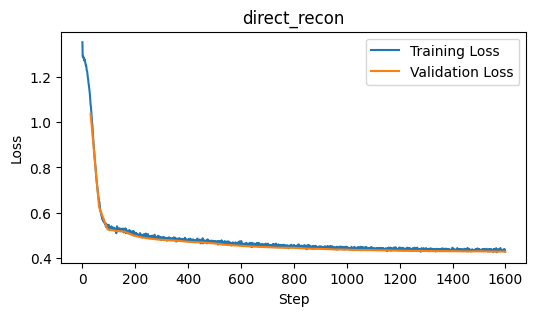

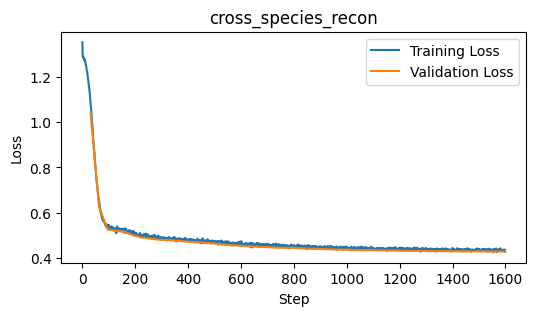

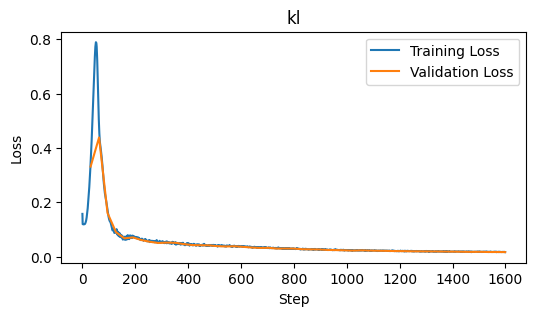

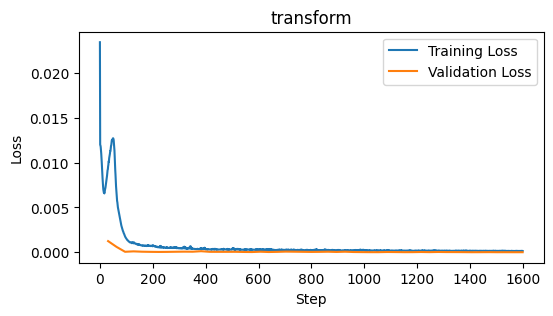

In [7]:
# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["direct_recon", "cross_species_recon", "kl", "transform"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}'][df[f'val_{loss_type}'] != 0.0]
    val_step = df['step'][df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

    
best_model_path = trainer.callbacks[-1].best_model_path
print("Best model path:", best_model_path)
# # Load the checkpoint
# checkpoint = torch.load(best_model_path)

# # Create a new model with the same hyperparameters and homology information
# model = CrossSpeciesVAE(
#     homology_edges=homology_edges,  # Need to pass these again
#     **checkpoint['hyper_parameters']  # This loads all other hyperparameters
# )

# # Load the state dict
# model.load_state_dict(checkpoint['state_dict'])

# Saving
# save_dict = {
#     'state_dict': model.state_dict(),
#     'hyper_parameters': model.hparams,
#     'epoch': 99,
# }
# torch.save(save_dict, f'manual_checkpoint_epoch_{99}.pt')

In [8]:
output, s = model.get_latent_embeddings(species_data_sub, batch_size=4096)
s=s.cpu().numpy()

In [9]:
plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())

<Figure size 640x480 with 0 Axes>

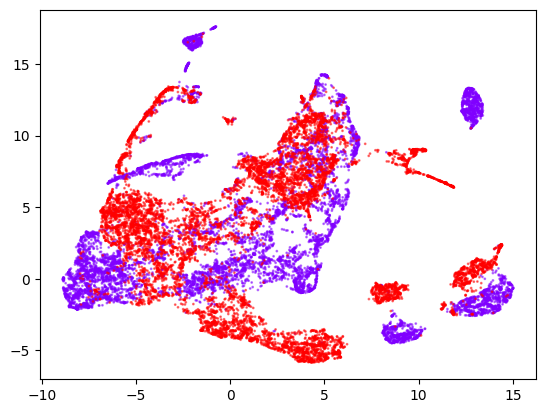

In [10]:
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

0.4108827357420968
0.3475327647169797


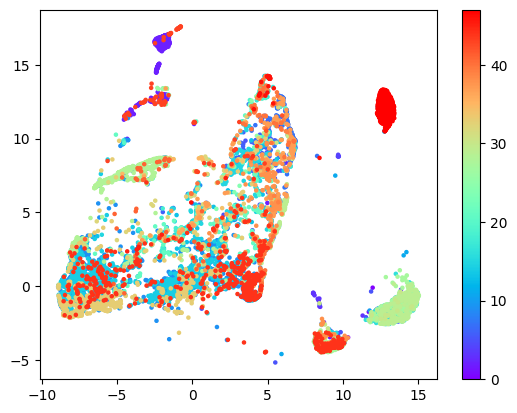

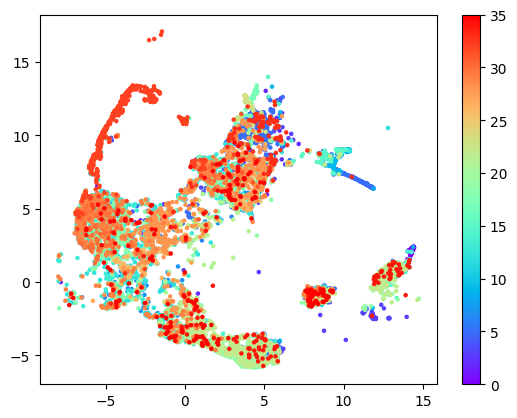

In [11]:

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['wagner'], species_data_sub['briggs']], ['cell_type', 'cell_type']):
    dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = dt
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
    plt.figure();
    plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    

In [12]:
import numpy as np
import plotly.io as pio
pio.renderers.default = "notebook"



import plotly.graph_objects as go
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import plotly.io as pio
pio.renderers.default = 'notebook'
def create_sankey_from_similarity(
    similarity_matrix: np.ndarray,
    source_labels: list,
    target_labels: list,
    threshold: float = 0.1,
    title: str = "Cross-species Label Similarity",
    width: int = 1000,
    height: int = 800
) -> go.Figure:
    """
    Create a Sankey diagram from a bipartite similarity matrix with weighted edges.
    """
    # Create node labels
    labels = source_labels + target_labels
    
    # Create source, target, and value arrays for links
    sources = []
    targets = []
    values = []
    
    # Create hover text for links
    link_labels = []
    
    # Iterate through similarity matrix
    for i in range(similarity_matrix.shape[0]):
        for j in range(similarity_matrix.shape[1]):
            if similarity_matrix[i,j] > threshold:
                sources.append(i)
                targets.append(j + len(source_labels))
                values.append(similarity_matrix[i,j])
                link_labels.append(f"{source_labels[i]} → {target_labels[j]}: {similarity_matrix[i,j]:.3f}")
    
    # Normalize values to make them more visually appealing
    values = np.array(values)
    values = values / values.max() * 100  # Scale to 0-100 range for better visualization
    
    # Create color arrays for nodes
    node_colors = ['#1f77b4'] * len(source_labels) + ['#ff7f0e'] * len(target_labels)
    
    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node = dict(
            pad = 15,
            thickness = 20,
            line = dict(color = "black", width = 0.5),
            label = labels,
            color = node_colors
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values,
            customdata = link_labels,
            color = ['rgba(31, 119, 180, 0.4)'] * len(sources),  # Semi-transparent links
            hovertemplate = '%{customdata}<extra></extra>'
        )
    )])
    
    # Update layout
    fig.update_layout(
        title_text=title,
        font_size=12,
        width=width,
        height=height,
        showlegend=False,
        margin=dict(t=40, l=40, r=40, b=40)
    )
    
    # Display in notebook
    # fig.show(renderer="notebook")
    return fig

K = 50
latent = output.cpu().numpy()
indices, distances = find_nearest_neighbors(latent[s==1],latent[s==0], n_neighbors=K)


cl1 = np.array(list(species_data_sub['wagner'].obs['cell_type']))
cl2 = np.array(list(species_data_sub['briggs'].obs['cell_type']))

clu1,cluc1 = np.unique(cl1, return_counts=True)
clu2,cluc2 = np.unique(cl2, return_counts=True)
# clu3,cluc3 = np.unique(cl3, return_counts=True)

C = np.zeros((clu1.size,clu2.size))


df = pd.DataFrame();
df['labels_0'] = cl1[indices.flatten()]
df['labels_1'] = cl2[np.tile(np.arange(indices.shape[0])[:,None],(1,K)).flatten()]
df['distances'] = 1-distances.flatten()
df = df.groupby(['labels_0','labels_1']).sum().reset_index()

C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['distances'].values
C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)

In [13]:
fig = create_sankey_from_similarity(C, list(clu1), list(clu2), threshold=5)
fig.write_image('t3.png')
